# Confirming transit route quality in UrbanAccess + Pandana

Sam Maurer - October 2020

This notebook is part of an investigation into a reported issue where adding a subway network had the unexpected effect of _reducing_ accessibility (jobs within 15 minutes) for certain locations.

This notebook checks whether the problem comes from the routing itself. Pandana uses contraction hierarchies to speed up shortest path calculations. Fast links are prioritized in the network, so I thought perhaps adding a subway caused some routing to shift to rail even when that wasn't strictly optimal.

But the routing is fine. This notebook loads both versions of the network, draws random locations, and checks the travel times. See separate notebook demonstrating the actual problem, which turns out be related to how jobs are linked up with network nodes.

In [1]:
import numpy as np
import pandas as pd

import pandana
import urbanaccess

In [2]:
print(np.__version__)
print(pd.__version__)
print(pandana.__version__)
print(urbanaccess.__version__)

1.19.1
1.1.2
0.5.1
0.2.1


In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Can only reliably work with one UA network in memory at a time, so set up functions to switch between them.

You can download the two network files here. UrbanAccess expects them to be inside a 'data' folder.
- https://www.dropbox.com/s/sfhdx1zy6ul9v2j/actransit_with_headways.h5?dl=1
- https://www.dropbox.com/s/baqzsn587xwjxen/actransit_bart_with_headways.h5?dl=1

In [4]:
def load_net1():
    return urbanaccess.network.load_network(filename='actransit_with_headways.h5')

In [5]:
def load_net2():
    return urbanaccess.network.load_network(filename='actransit_bart_with_headways.h5')

### Load both networks into Pandana

Net 1 is walk + ACTransit:

In [6]:
%%time
ua_net = load_net1()
net1 = pandana.Network(ua_net.net_nodes["x"],
                       ua_net.net_nodes["y"],
                       ua_net.net_edges["from_int"],
                       ua_net.net_edges["to_int"],
                       ua_net.net_edges[["weight"]], 
                       twoway=False)

Successfully read store: data/actransit_with_headways.h5 with the following keys: ['/edges', '/nodes']
Successfully read store: data/actransit_with_headways.h5 with the following keys: ['/edges', '/nodes']
CPU times: user 1min 57s, sys: 2.61 s, total: 2min
Wall time: 19.5 s


Net 2 is walk + ACTransit + BART

In [7]:
%%time
ua_net = load_net2()
net2 = pandana.Network(ua_net.net_nodes["x"],
                       ua_net.net_nodes["y"],
                       ua_net.net_edges["from_int"],
                       ua_net.net_edges["to_int"],
                       ua_net.net_edges[["weight"]], 
                       twoway=False)

Successfully read store: data/actransit_bart_with_headways.h5 with the following keys: ['/edges', '/nodes']
Successfully read store: data/actransit_bart_with_headways.h5 with the following keys: ['/edges', '/nodes']
CPU times: user 2min 14s, sys: 3.35 s, total: 2min 17s
Wall time: 21.9 s


### Set up a mapping for the OSM node ids

We want to draw origins and destinations from the OSM (walk network) nodes, not the transit stop nodes. UrbanAccess assigns its own node ids to the integrated networks, which don't match -- but the original OSM node ids are also stored. This sets up a mapping.

In [8]:
ua_net = load_net1()

osm_nodes = ua_net.net_nodes.loc[ua_net.net_nodes.net_type == 'walk']
osm_nodes.head(3)

Successfully read store: data/actransit_with_headways.h5 with the following keys: ['/edges', '/nodes']
Successfully read store: data/actransit_with_headways.h5 with the following keys: ['/edges', '/nodes']


,id,x,y,net_type
id_int,,,,
3660,30366199,-122.281347,37.828045,walk
3661,30366200,-122.280475,37.828248,walk
3662,30374146,-122.287497,37.802534,walk


In [9]:
osm_ids_1 = osm_nodes.id.values
ids_int_1 = osm_nodes.index.values

df1 = pd.DataFrame({'osm_id': osm_ids_1, 'id_int_1': ids_int_1})
df1.head(3)

,osm_id,id_int_1
0,30366199,3660
1,30366200,3661
2,30374146,3662


In [10]:
ua_net = load_net2()
osm_nodes = ua_net.net_nodes.loc[ua_net.net_nodes.net_type == 'walk']

osm_ids_2 = osm_nodes.id.values
ids_int_2 = osm_nodes.index.values

df2 = pd.DataFrame({'osm_id': osm_ids_2, 'id_int_2': ids_int_2})
df2.head(3)

Successfully read store: data/actransit_bart_with_headways.h5 with the following keys: ['/edges', '/nodes']
Successfully read store: data/actransit_bart_with_headways.h5 with the following keys: ['/edges', '/nodes']


,osm_id,id_int_2
0,30366199,3704
1,30366200,3705
2,30374146,3706


In [11]:
nodes = pd.merge(df1, df2, how='inner', on='osm_id')
nodes.head(3)

,osm_id,id_int_1,id_int_2
0,30366199,3660,3704
1,30366200,3661,3705
2,30374146,3662,3706


### Draw some random origins and destinations and compare travel times between networks

In [12]:
origs = nodes.sample(10)
dests = nodes.sample(10)

In [13]:
tt1 = net1.shortest_path_lengths(origs.id_int_1, dests.id_int_1)
print(tt1)

[38.287, 22.13, 72.947, 41.914, 75.955, 28.963, 75.286, 36.798, 110.501, 45.06]


In [14]:
tt2 = net2.shortest_path_lengths(origs.id_int_2, dests.id_int_2)
print(tt2)

[38.287, 22.13, 72.947, 41.914, 47.945, 28.963, 57.019, 36.798, 68.998, 45.06]


All the trips are the same or shorter, which is what we want to see

### What's the distribution of travel time change, with a larger number of trips?

In [15]:
%%time
n = 10000

origs = nodes.sample(n)
dests = nodes.sample(n)

tt1 = net1.shortest_path_lengths(origs.id_int_1, dests.id_int_1)
tt2 = net2.shortest_path_lengths(origs.id_int_2, dests.id_int_2)

dist_df = pd.DataFrame({'orig': origs.osm_id.values, 
                        'dest': dests.osm_id.values, 
                        'tt1': tt1, 
                        'tt2': tt2})

dist_df['ratio'] = dist_df.tt2/dist_df.tt1

CPU times: user 2.14 s, sys: 76.1 ms, total: 2.21 s
Wall time: 336 ms


In [16]:
dist_df.describe()

,tt1,tt2,ratio
count,1.000000e+04,1.000000e+04,9999.000000
mean,8.239645e+03,8.223105e+03,0.840477
std,1.870412e+05,1.870420e+05,0.165461
min,0.000000e+00,0.000000e+00,0.180312
25%,4.807875e+01,4.237475e+01,0.714775
50%,6.953200e+01,5.636450e+01,0.878044
75%,9.941525e+01,7.319950e+01,1.000000
max,4.294967e+06,4.294967e+06,1.000000


#### No trips take longer, which is exactly what we'd want -- but it makes the original findings of reduced accessibility in certain places a complete mystery

### Look at some routings in detail

In [17]:
def nodes_to_edges(nodes):
    return pd.DataFrame({'from_int': nodes[:-1], 'to_int': nodes[1:]})

In [18]:
nodes = net1.shortest_path(12621, 46884)
print(nodes)

[12621 12622  6916 12623  2109  2110  2111  2112  2113  2114  2115  2116
  2117 31109 50394 50395 16911 16910 53719  2640  2641  2642  2643  2644
 46868 46869 46871 32884 23579 23577 32903  4235 32904 32905 46880  8200
 32906 46882 46883 46884]


In [19]:
ua_net = load_net1()
df = nodes_to_edges(nodes).merge(ua_net.net_edges, how='left', on=['from_int','to_int'])
df[df.weight.notnull()]

Successfully read store: data/actransit_with_headways.h5 with the following keys: ['/edges', '/nodes']
Successfully read store: data/actransit_with_headways.h5 with the following keys: ['/edges', '/nodes']


,from_int,to_int,weight,unique_agency_id,unique_trip_id,sequence,edge_id,route_type,unique_route_id,net_type,from,to,distance,name,ref,highway,service,bridge,tunnel,access,oneway,lanes,maxspeed,hgv,area,width,est_width,junction,mean,node_id_route
0,12621,12622,0.988228,NaN,NaN,NaN,NaN,NaN,NaN,walk,53110672,53110674,79.519740,Mound Street,NaN,residential,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12622,6916,0.986759,NaN,NaN,NaN,NaN,NaN,NaN,walk,53110674,53045525,79.401533,Mound Street,NaN,residential,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6916,12623,1.056204,NaN,NaN,NaN,NaN,NaN,NaN,walk,53045525,53110677,84.989553,Mound Street,NaN,residential,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12623,2109,11.167931,NaN,NaN,NaN,NaN,NaN,NaN,osm to transit,53110677,0101110_ac_transit_O-141_ac_transit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.802381,0101110_ac_transit_O-141_ac_transit
4,12623,2109,11.167931,NaN,NaN,NaN,NaN,NaN,NaN,osm to transit,53110677,0101110_ac_transit_O-141_ac_transit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.802381,0101110_ac_transit_O-141_ac_transit
5,12623,2109,11.167931,NaN,NaN,NaN,NaN,NaN,NaN,osm to transit,53110677,0101110_ac_transit_O-141_ac_transit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.802381,0101110_ac_transit_O-141_ac_transit
6,12623,2109,11.167931,NaN,NaN,NaN,NaN,NaN,NaN,osm to transit,53110677,0101110_ac_transit_O-141_ac_transit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.802381,0101110_ac_transit_O-141_ac_transit
7,12623,2109,11.167931,NaN,NaN,NaN,NaN,NaN,NaN,osm to transit,53110677,0101110_ac_transit_O-141_ac_transit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.802381,0101110_ac_transit_O-141_ac_transit
8,12623,2109,11.167931,NaN,NaN,NaN,NaN,NaN,NaN,osm to transit,53110677,0101110_ac_transit_O-141_ac_transit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.802381,0101110_ac_transit_O-141_ac_transit
9,12623,2109,11.167931,NaN,NaN,NaN,NaN,NaN,NaN,osm to transit,53110677,0101110_ac_transit_O-141_ac_transit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.802381,0101110_ac_transit_O-141_ac_transit


### Visualize routings

In [20]:
import matplotlib
from matplotlib import pyplot as plt

print(matplotlib.__version__)

3.3.1


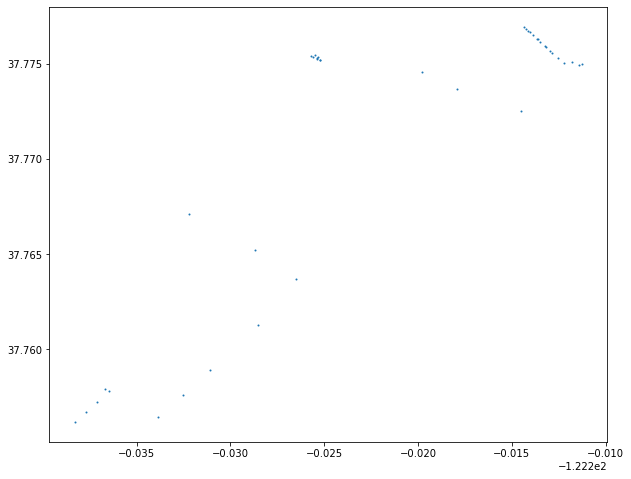

In [22]:
fig, ax = plt.subplots(figsize=(10,8))
net = ua_net.net_nodes.reindex(net1.shortest_path(12621, 46884))
plt.scatter(net.x, net.y, s=1)
plt.show()